## Visualizing the dataset

In [1]:
import pyphysics as phys
import uproot
import awkward as ak
import hist
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### What should we expect from the energy-loss profile on gas?


In [7]:
df1 = uproot.open("./Outputs/tree_11Li_2H_1H_Ex_0.00.root:SimulationTree").arrays(library="pd") 
df2 = uproot.open("./Outputs/tree_11Li_2H_2H_Ex_0.00.root:SimulationTree").arrays(library="pd") 
df3 = uproot.open("./Outputs/tree_11Li_2H_3H_Ex_0.00.root:SimulationTree").arrays(library="pd") 

parts = ["p", "d", "t"]
dfs = [df1, df2, df3]
for i,df in enumerate(dfs):
    df = df.drop(columns=["profx"])
    df["profy"] = df["profy"].apply(lambda x : np.array(x))
    df["label"] = parts[i]
    dfs[i] = df

In [8]:
dfs[0].memory_usage(deep=True) / (1024*1024)

Index        0.000122
dEgas        0.408127
dE0          0.408127
dE1          0.408127
T3           0.408127
theta3       0.408127
RPx          0.408127
T3After1     0.408127
profy       65.300293
label        2.958920
dtype: float64

In [9]:
df = pd.concat(dfs)
df.head()

,dEgas,dE0,dE1,T3,theta3,RPx,T3After1,profy,label
0,0.218267,11.479183,8.230044,20.108731,34.441817,254.680336,0.000000,"[0.0004191933840047568, 0.0, 0.0, 0.0, 0.0, 0....",p
1,0.305491,8.457327,15.478861,24.344296,22.309028,148.015405,0.000000,"[0.0007218921091407537, 0.000720073061529547, ...",p
2,-0.042595,7.362828,13.566279,24.217738,21.008768,219.022179,3.314466,"[0.0007668694597668946, 0.0007578445947729051,...",p
3,0.094662,7.521955,12.172503,25.118176,16.637236,187.528524,5.319978,"[0.0003882489399984479, 0.0003868640342261642,...",p
4,0.149947,6.148745,10.291179,25.523476,17.121025,199.394260,8.963668,"[0.00023248372599482536, 0.0002352454903302714...",p


In [10]:
## Kinematics plot
hkins = {}
for part in parts:
    hkin = hist.Hist.new.Reg(300, 0, 80, label="theta [deg]").Reg(300, 0, 80, label="Elab [MeV]").Double()
    gated = df[df.label == part]
    hkin.fill(gated.theta3, gated.T3)
    hkins[part] = hkin


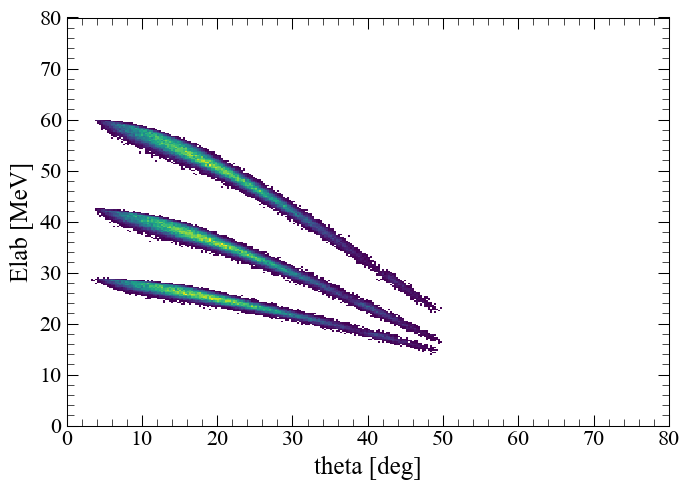

In [11]:
fig, ax = plt.subplots(1, 1)
for i, p in enumerate(parts):
    hkins[p].plot(ax=ax, cmin=1, cbar=None)
fig.tight_layout()

In [12]:
## Gate on events with same initial conditions
Tini = 25
theta3 = 40
RPx = 220
offset = 5

gate = (
    (df.T3 >= Tini - offset) & (df.T3 <= Tini + offset) &
    (df.theta3 >= theta3 - offset) & (df.theta3 <= theta3 + offset) &
    (df.RPx >= RPx - offset) & (df.RPx <= RPx + offset)
)

gated = df[gate]

counts = np.unique(gated.label, return_counts=True)
counts

(array(['d', 'p', 't'], dtype=object), array([283,  16,   2]))

/home/miguel/venv/lib/python3.10/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


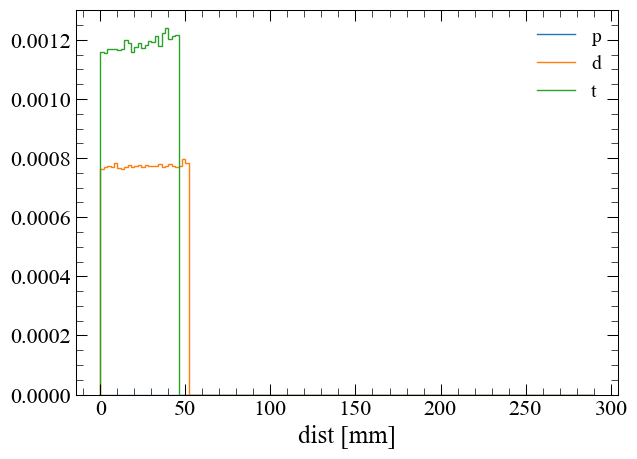

In [22]:
fig, ax = plt.subplots(1, 1)
for p in ["p", "d", "t"]:
    if not len(gated[gated.label == p]):
        continue
    proj = gated[gated.label == p].iloc[0]["profy"]
    h = hist.Hist.new.Reg(145, 0, 290, label="dist [mm]").Double()
    h[...] = proj
    h.plot(histtype="step", yerr=False,label=p)
ax.legend()

Let's simulate energy profiles for the different particles

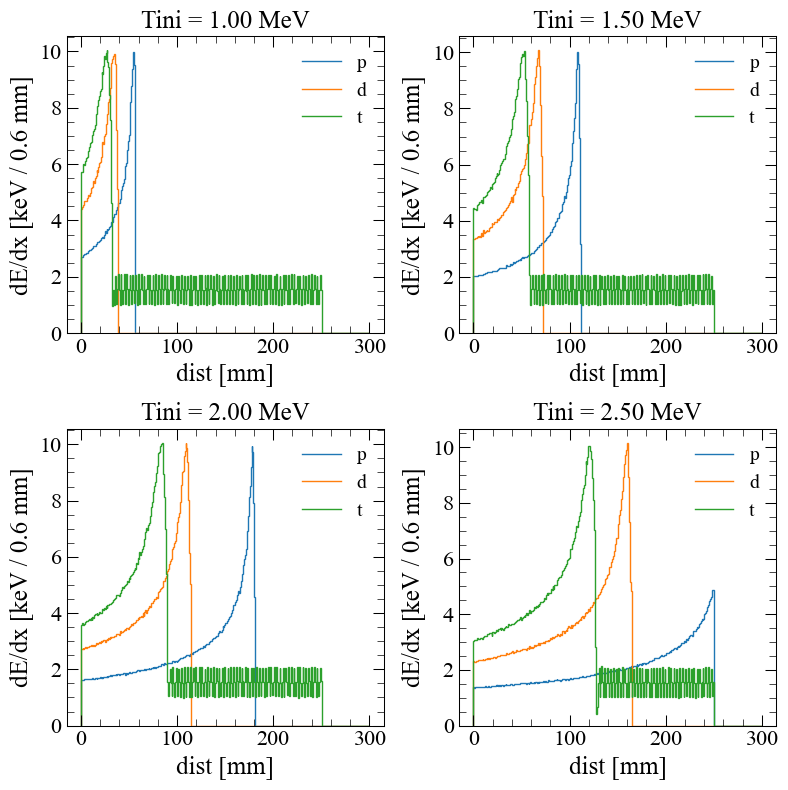

In [22]:
def build_profile(el: phys.EnergyLoss, key: str, Tini: float, dist: float, h: hist.BaseHist):
    niter = 10
    nstep = 1000
    dx = dist / nstep
    for _ in range(niter):
        Taux = Tini
        for i in range(nstep):
            Tafter = el.slow(key, Taux, dx)
            if Tafter <= 0:
                break
            deltaE = (Taux - Tafter) * 1e3
            if deltaE < 0:
                deltaE = 0
            deltaE = np.random.normal(deltaE, deltaE * 0.05)
            Taux = Tafter
            h.fill(dx * i, sample=[deltaE])

h = hist.Hist.new.Reg(350, 0, 300, label="dist [mm]").Mean()

el = phys.EnergyLoss()
el.read("p", "./Inputs/SRIM/1H_900mb_CF4_90-10.txt")
el.read("d", "./Inputs/SRIM/2H_900mb_CF4_90-10.txt")
el.read("t", "./Inputs/SRIM/3H_900mb_CF4_90-10.txt")
# el.read("11Li", "./Inputs/SRIM/11Li_900mb_CF4_90-10.txt")

dist = 250
energies = np.arange(1, 3, 0.5)
n = int(np.ceil(np.sqrt(len(energies))))
fig, axs = plt.subplots(n, n, figsize=(4*n, 4*n))
for i, e in enumerate(energies):
    ax = axs.flat[i]
    for p in el.keys:
        hit = h.copy()
        hit.reset()
        build_profile(el, p, e, dist, hit)
        hit.plot(ax=ax, histtype="step", yerr=False, label=p)
    ax.set_title(f"Tini = {e:.2f} MeV")
    ax.set_ylabel("dE/dx [keV / 0.6 mm]")
    ax.legend()
fig.tight_layout()

# hs = [h.copy() for i in range(len(el.keys))]

# Tini =  30
# dist = 110
# for i, p in enumerate(el.keys):
#     build_profile(el, p, Tini, dist, hs[i])
#     hs[i].plot(histtype="step", yerr=False, label=p)
# plt.ylabel("dE/dx [keV / 0.6 mm]")
# plt.legend()

